# Garbage dataset classification

In this notebook, we will develop a model classifying garbage pictures into 6 categories: `['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']`.
<br> You may find the dataset on kaggle [Garbage dataset](https://www.kaggle.com/datasets/zlatan599/garbage-dataset-classification)



In [28]:
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import typing as t
import tensorflow as tf
import numpy as np

# Check if CUDA is successfully installed.
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
        
print("TensorFlow version:", tf.__version__)
print("GPU available :", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.20.0
GPU available : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# I - Metadata oversight

In [29]:
# Load csv
metadata = pd.read_csv(Path("Garbage_Dataset_Classification/metadata.csv"))
metadata.sample(frac=0.5).head()

,filename,label
4170,plastic_01378.jpg,plastic
1386,cardboard_01360.jpg,cardboard
7309,metal_01651.jpg,metal
7985,metal_02635.jpg,metal
562,cardboard_01587.jpg,cardboard


Let's investigate our label distribution

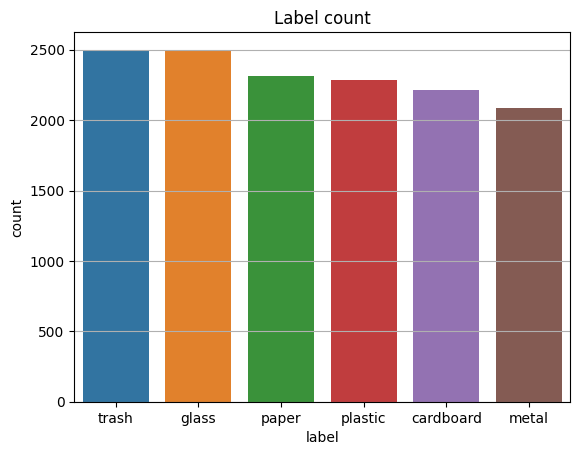

In [30]:
def plot_label_distribution(
    metadata_df: pd.DataFrame,
    label_column: str = "label",
    title: str = "Label count",
    y_lim: t.Optional[t.Tuple[int, int]] = None,
):
    """Plot the label distribution as barplots.

    Args:
        metadata (pd.DataFrame): The metadata dataframe.
        label_column (str, optional): name of the label column.
            Defaults to "label".
        title (str, optional): Title of the figure. Defaults to "label count"
        y_lim (tuple, optional): y_lim tuple. See matplotlib docs.
            Defaults to None.

    """
    label_distribution = pd.DataFrame(
        metadata_df[label_column].value_counts()
    ).reset_index()

    plt.title(title)
    plt.grid()
    sns.barplot(label_distribution, x=label_column, y="count", hue=label_column)
    if y_lim:
        plt.ylim(y_lim)
    plt.show()


plot_label_distribution(metadata_df=metadata)

In [31]:
CLASSES = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
CLASSES

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [32]:
RAW_IMAGE_DIR = Path("Garbage_Dataset_Classification/images")


def compute_image_relative_path(
    row: pd.Series, raw_image_dir: Path = RAW_IMAGE_DIR, to_str: bool = True
)->t.Union[Path, str]:
    """Compute image relative path.

    Args:
        row (pd.Series): A pandas series rows. Must have a `label` field.
        raw_image_dir (Path, optional): Directory where raw images are stored.
            Defaults to `RAW_IMAGE_DIR`.
        to_str (bool, optional): convert posix path to string.
            Defaults to True.

    Returns:
        Union[Path, str]: The image relative path.
        
    """
    image_path = raw_image_dir.joinpath(row["label"], row["filename"])
    if to_str:
        # tensorflow doesn't handle Posix Path well. Use string instead.
        image_path = str(image_path)
    return image_path


metadata["filename"] = metadata.apply(compute_image_relative_path, axis=1)
metadata

,filename,label
0,Garbage_Dataset_Classification/images/cardboar...,cardboard
1,Garbage_Dataset_Classification/images/cardboar...,cardboard
2,Garbage_Dataset_Classification/images/cardboar...,cardboard
3,Garbage_Dataset_Classification/images/cardboar...,cardboard
4,Garbage_Dataset_Classification/images/cardboar...,cardboard
...,...,...
13896,Garbage_Dataset_Classification/images/paper/pa...,paper
13897,Garbage_Dataset_Classification/images/paper/pa...,paper
13898,Garbage_Dataset_Classification/images/paper/pa...,paper
13899,Garbage_Dataset_Classification/images/paper/pa...,paper


# II - Dataset processing
## a. Split the dataset into Train, valid and test split
- train split: data to train the model
- valid split: data to supervise model training.
- test split: data split to evaluate model performance.

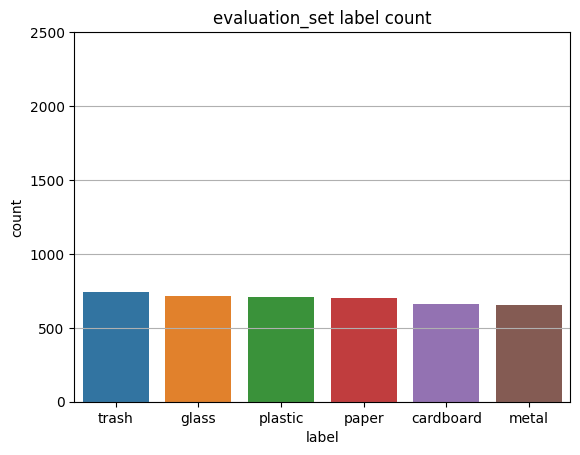

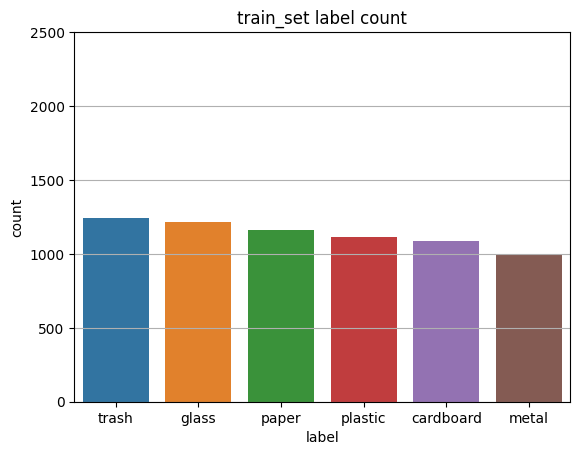

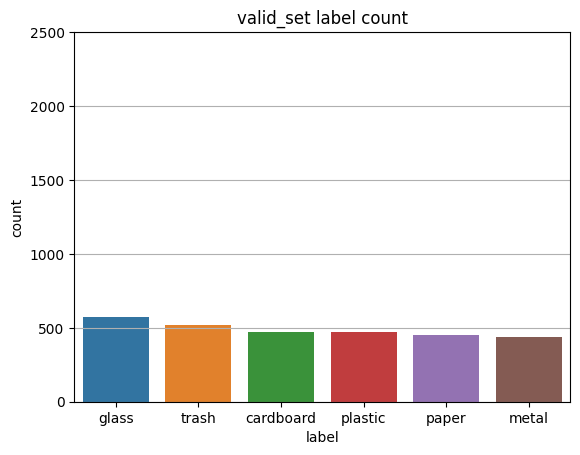

In [33]:
# Dataset to Train-valid and Eval set
# - Split en train (70%), eval (30%)
X_train_valid, X_eval, y_train_valid, y_eval = sklearn.model_selection.train_test_split(
    metadata["filename"],
    metadata["label"],
    test_size=0.3,
    random_state=42,
)

EVALUATION_SET = pd.concat([X_eval, y_eval], axis=1)


y_lim = [0, 2500]
plot_label_distribution(
    metadata_df=EVALUATION_SET,
    label_column="label",
    title="evaluation_set label count",
    y_lim=y_lim
)

train_valid_set = pd.concat([X_train_valid, y_train_valid], axis=1)

# Dataset to Train and valid set
# - Split en train (70%), valid (30%)
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(
    train_valid_set["filename"],
    train_valid_set["label"],
    test_size=0.3,
    random_state=42,
)


TRAIN_SET = pd.concat([X_train, y_train], axis=1)
VALID_SET = pd.concat([X_val, y_val], axis=1)


plot_label_distribution(
    metadata_df=TRAIN_SET,
    label_column="label",
    title="train_set label count",
    y_lim=y_lim
)
plot_label_distribution(
    metadata_df=VALID_SET,
    label_column="label",
    title="valid_set label count",
    y_lim=y_lim
)

In [34]:
# Serialize our split to .csv file.
SPLIT_DICT = {"EVALUATION_SET" : EVALUATION_SET, "TRAIN_SET":TRAIN_SET, "VALID_SET": VALID_SET}
for split_name, split_df in SPLIT_DICT.items():
    split_df.to_csv(Path(split_name).with_suffix(".csv"))
EVALUATION_SET.sample(frac=1).head()

,filename,label
5834,Garbage_Dataset_Classification/images/glass/gl...,glass
6118,Garbage_Dataset_Classification/images/glass/gl...,glass
7053,Garbage_Dataset_Classification/images/metal/me...,metal
5970,Garbage_Dataset_Classification/images/glass/gl...,glass
549,Garbage_Dataset_Classification/images/cardboar...,cardboard


## b. Build tensorflow dataset
> load images and encode labels to one hot vectors

In [35]:
label_to_index = tf.lookup.KeyValueTensorInitializer(
    keys=tf.constant(CLASSES),
    values=tf.constant(list(range(len(CLASSES))), dtype=tf.int64),
)
label_to_index = tf.lookup.StaticHashTable(label_to_index, default_value=-1)


def one_hot_encode(
    features: np.ndarray, label: str, num_classes=len(CLASSES)
) -> t.Tuple[tf.Tensor, tf.Tensor]:
    """Encode label to one hot encoded vector.

    Args:
        features (np.ndarray): Features array ```(here it is image matrix)```.
        label (str): The label name.
        num_classes (_type_, optional): The number of classes.
            Defaults to len(CLASSES).

    Returns:
        Tuple[tf.Tensor, tf.Tensor]: A 2-Tuple containing features and the one
        hot label vector.

    Note:
        - Features are not processed in this function.
        - This function is designed to work with the tf.data.Dataset.map() method.

    """
    label_encoded = label_to_index.lookup(label)  # string to integer
    one_hot = tf.one_hot(label_encoded, num_classes)  # int to one hot vector
    return features, one_hot


def load_image(
    path_to_image: str, label: t.Optional[str] = None
) -> t.Tuple[tf.Tensor, tf.Tensor]:
    """Load and process image.

    Args:
        path_to_image (str): Path to image.
        label (t.Optional[str], optional): Label name. Defaults to None.

    Returns:
        Tuple[tf.Tensor, tf.Tensor]: A 2-Tuple containing features and the one
            hot label vector.
    """
    img = tf.io.read_file(path_to_image)
    img = tf.image.decode_jpeg(img, channels=3)  # rgb image
    img = tf.image.resize(img, [256, 256])  # 256x256 image
    img = img / 255.0  # Normalize [0,1]
    return img, label


def build_image_dataset(
    metadata_df: pd.DataFrame, batch_size: int = 16
) -> tf.data.Dataset:
    """Build image dataset.

    Compute a image dataset with the given dataframe:
    - load and process images.
    - encode label to one hot vectors.

    Args:
        metadata_df (pd.DataFrame): A metadata dataframe.

    Returns:
        tf.data.Dataset: A tensorflow dataset containing images and labels.

    """
    tf_dataset = tf.data.Dataset.from_tensor_slices(
        (metadata_df["filename"], metadata_df["label"])
    )
    tf_dataset = tf_dataset.map(load_image)
    tf_dataset = tf_dataset.map(one_hot_encode)
    return (
        tf_dataset.batch(batch_size)
        .cache()
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )


# Render dataset for each data split.
tf_eval_dataset = build_image_dataset(EVALUATION_SET)
tf_train_dataset = build_image_dataset(TRAIN_SET)
tf_valid_dataset = build_image_dataset(VALID_SET)

# III. Model training
We will use the ResNet50 as base model and fine-tune it to our case study.

In [36]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models


# Load pretrained ResNet50
base_model = ResNet50(
    weights="imagenet", include_top=False, input_shape=(256, 256, 3)
)
base_model.trainable = True

garbage_cnn = models.Sequential(
    [
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation="relu"),
        layers.Dense(
            len(CLASSES), activation="sigmoid"
        ),
    ]
)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)


garbage_cnn.compile(
    optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
)

> Define callbacks

In [37]:
from tensorflow.keras.callbacks import (
    EarlyStopping,
    TensorBoard,
    # ModelCheckpoint,
    # ReduceLROnPlateau,
)
import datetime

early_stop = EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

# tensorboard settings
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(
    log_dir=log_dir, histogram_freq=1, update_freq="epoch"
)

CALLBACKS = [tensorboard_callback, early_stop]

> **Train model**
<br>*(install cuda to use GPU for faster training)*

In [38]:
history_finetune = garbage_cnn.fit(
    tf_train_dataset,
    validation_data=tf_valid_dataset,
    epochs=100,
    callbacks=CALLBACKS,
)

Epoch 1/100


2025-09-29 12:23:12.541945: I external/local_xla/xla/service/service.cc:163] XLA service 0x7ca5040042a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-29 12:23:12.541978: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2025-09-29 12:23:13.036620: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-29 12:23:15.658184: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
2025-09-29 12:23:17.018533: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[16,64,64,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,64,64,64]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_cal

425/426 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.4746 - loss: 0.4315

2025-09-29 12:25:06.647827: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[11,64,64,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[11,64,64,64]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-09-29 12:25:07.002107: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[11,128,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[11,128,32,32]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target

426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.4751 - loss: 0.4312

2025-09-29 12:25:29.966890: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[7,64,64,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[7,64,64,64]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-09-29 12:25:30.223389: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[7,128,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[7,128,32,32]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__

426/426 ━━━━━━━━━━━━━━━━━━━━ 155s 291ms/step - accuracy: 0.6585 - loss: 0.3028 - val_accuracy: 0.2861 - val_loss: 0.4734
Epoch 2/100
426/426 ━━━━━━━━━━━━━━━━━━━━ 101s 237ms/step - accuracy: 0.9043 - loss: 0.1164 - val_accuracy: 0.7033 - val_loss: 0.2355
Epoch 3/100
426/426 ━━━━━━━━━━━━━━━━━━━━ 96s 226ms/step - accuracy: 0.9723 - loss: 0.0529 - val_accuracy: 0.9222 - val_loss: 0.0829
Epoch 4/100
426/426 ━━━━━━━━━━━━━━━━━━━━ 97s 228ms/step - accuracy: 0.9943 - loss: 0.0220 - val_accuracy: 0.9243 - val_loss: 0.0770
Epoch 5/100
426/426 ━━━━━━━━━━━━━━━━━━━━ 104s 244ms/step - accuracy: 0.9987 - loss: 0.0096 - val_accuracy: 0.9239 - val_loss: 0.0769
Epoch 6/100
426/426 ━━━━━━━━━━━━━━━━━━━━ 98s 229ms/step - accuracy: 0.9997 - loss: 0.0047 - val_accuracy: 0.9246 - val_loss: 0.0789
Epoch 7/100
426/426 ━━━━━━━━━━━━━━━━━━━━ 97s 227ms/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 0.9246 - val_loss: 0.0816
Epoch 8/100
426/426 ━━━━━━━━━━━━━━━━━━━━ 97s 228ms/step - accuracy: 1.0000 - loss: 0.

# IV - Evaluate

In [39]:
prediction = garbage_cnn.predict(tf_eval_dataset)

261/261 ━━━━━━━━━━━━━━━━━━━━ 17s 57ms/step


In [40]:
# Binarize prediction to simplify evaluation 
y_pred = (prediction > 0.5).astype(int)  
y_pred

array([[0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0]], shape=(4171, 6))

In [41]:
y_true = np.concatenate([y for x, y in tf_eval_dataset], axis=0)
y_true

array([[0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], shape=(4171, 6), dtype=float32)

> **Scores**

In [42]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(
    y_true, y_pred, average="macro"
)  # 'micro' ou 'weighted' selon le besoin
recall = recall_score(y_true, y_pred, average="macro")
f1 = f1_score(y_true, y_pred, average="macro")

print("\t MODEL PERFORMANCE")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

	 MODEL PERFORMANCE
Accuracy: 0.8866
Precision: 0.9399
Recall: 0.8998
F1-score: 0.9193


> **Confusion matrix**

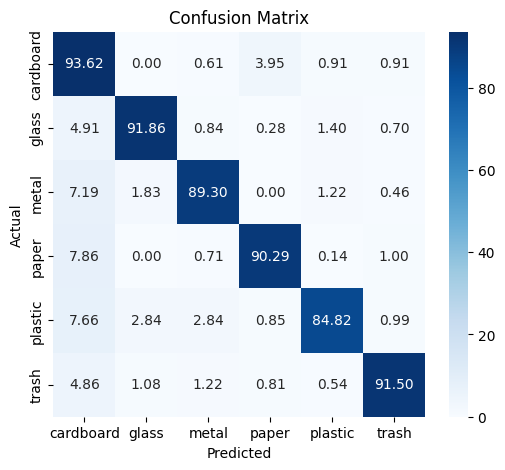

,Predicted cardboard,Predicted glass,Predicted metal,Predicted paper,Predicted plastic,Predicted trash
Actual cardboard,93.617,0.000,0.608,3.951,0.912,0.912
Actual glass,4.909,91.865,0.842,0.281,1.403,0.701
Actual metal,7.187,1.835,89.297,0.000,1.223,0.459
Actual paper,7.857,0.000,0.714,90.286,0.143,1.000
Actual plastic,7.660,2.837,2.837,0.851,84.823,0.993
Actual trash,4.858,1.080,1.215,0.810,0.540,91.498


In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd

label_to_index = {label: i for i, label in enumerate(CLASSES)}
index_to_label = {v: k for k, v in label_to_index.items()}  # int -> string


def one_hot_decode(one_hot: tf.Tensor, index_to_label: t.Dict[int, str]) -> str:
    """Convert one hot vector to string label.

    Args:
        one_hot (tf.Tensor): One hot label vector.
        index_to_label: Dictionary mapping integer to string.

    Returns:
        str: String label name
    """
    class_index = tf.argmax(one_hot).numpy()  # récupérer l'indice
    label = index_to_label[class_index]  # convertir en string
    return label


def display_confusion_matrix(
    y_true: t.List[str],
    y_pred: t.List[str],
    labels: t.Optional[t.List[str]] = None,
):
    """
    Display a confusion matrix in a readable table format.

    Args:
        y_true (List[str]): True class labels.
        y_pred (List[str]): Predicted class labels.
        labels (List[str]): List of class labels to index the matrix.
            Defaults to None.
            
    """
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm = np.round(cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] * 100, 3)

    # Use labels for rows and columns if provided
    if labels is None:
        labels = sorted(list(set(y_true) | set(y_pred)))

    # Create a DataFrame for nice display
    cm_df = pd.DataFrame(
        cm,
        index=[f"Actual {l}" for l in labels],
        columns=[f"Predicted {l}" for l in labels],
    )

    # Create the heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt=".2f",
        xticklabels=labels,
        yticklabels=labels,
        cmap="Blues",
    )

    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.title("Confusion Matrix")
    plt.show()
    return cm_df


y_true_str = [one_hot_decode(i) for i in y_true]
y_pred_str = [one_hot_decode(i) for i in y_pred]
display_confusion_matrix(y_true_str, y_pred_str, labels=CLASSES)

# V - Short inference study.

In [ ]:
from PIL import Image
import io
import requests

def predict_on_file(
    model: tf.keras.Model,
    image_path: t.Optional[Path] = None,
    image_url: t.Optional[str] = None,
)->np.ndarray:
    """Predict on file.
    
    Compute model prediction on image (stored on disk or with url link).

    Args:
        model (tf.keras.Model): keras model.
        image_path (t.Optional[Path], optional): Path to image.
            Defaults to None.
        image_url (t.Optional[str], optional): Url of the image.
            Defaults to None.

    Returns:
        _np.ndarray: The prediction array.
        
    """

    feature = None
    if image_path:
        feature, _ = load_image(str(image_path))
        
    if image_url:
        response = requests.get(image_url)
        feature = Image.open(io.BytesIO(response.content))

        feature = np.array(feature)
        feature = tf.image.resize(feature, [256, 256])  # 256x256 image
        feature = feature / 255.0  # Normalize [0,1]

    feature = np.reshape(feature, (-1, 256, 256, 3))
    proba = model.predict(feature)
    return feature, proba


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


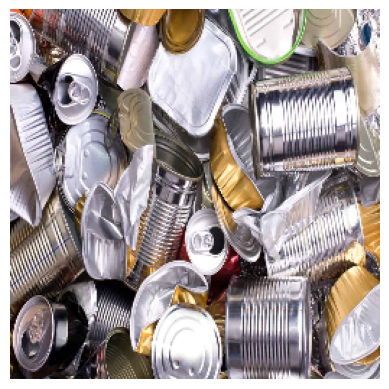

['0.00%', '0.01%', '99.74%', '0.23%', '0.00%', '0.02%'] metal


,cardboard,glass,metal,paper,plastic,trash
0,0.004587,0.011862,99.742683,0.229853,0.00454,0.02186


In [76]:
img, preds = predict_on_file(
    model=garbage_cnn,
    image_url="https://media.generalkinematics.com/wp-content/uploads/2023/04/iStock-491962627.jpg"
)
preds
# Exemple : features = np.random.rand(224,224,3)
plt.imshow(img[0])
plt.axis('off')  # cacher les axes
plt.show()


label_str = one_hot_decode(one_hot=preds[0])

arr_percent = preds * 100
preds_df = pd.DataFrame(arr_percent, columns=CLASSES)
# print(preds_df)


formatted = ["{:.2f}%".format(x) for x in arr_percent[0]]
print(formatted, label_str)
preds_df


In [77]:
!ls /home/arnaud/Pictures/Camera

'Photo from 2025-09-25 12-19-29.650015.jpeg'


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


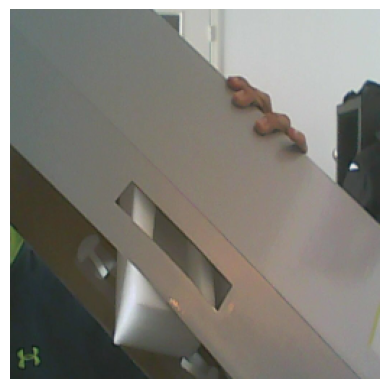

['52.25%', '0.08%', '0.16%', '14.85%', '0.05%', '0.03%'] cardboard


,cardboard,glass,metal,paper,plastic,trash
0,52.245701,0.077554,0.156938,14.847488,0.054648,0.034303


In [78]:
img, preds = predict_on_file(
    model=garbage_cnn,
    image_path="/home/arnaud/Pictures/Camera/Photo from 2025-09-25 12-19-29.650015.jpeg"
)
preds
# Exemple : features = np.random.rand(224,224,3)
plt.imshow(img[0])
plt.axis('off')  # cacher les axes
plt.show()


label_str = one_hot_decode(one_hot=preds[0])
arr_percent = preds * 100
preds_df = pd.DataFrame(arr_percent, columns=CLASSES)
# print(preds_df)
formatted = ["{:.2f}%".format(x) for x in arr_percent[0]]
print(formatted, label_str)
preds_df